# Manual for a Comprehensive A/B Testing

As a data analyst, it's crucial to grasp the A/B testing process comprehensively. This goes beyond just conducting the statistical test; analysts are now expected to design the experiment from its inception. This notebook aims to provide a thorough explanation of how to conduct A/B testing, covering every aspect of the process. It covers all the stuffs from the way we determine the sample size, statistical test we should use based on each scenario, and another approach to overcome some disadvantages of using a traditional test using Bayesian approach.

First, let's import some important libraries first and extract the dataset we're going to use for doing the example!

# 0. Extraction and Load the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We'll be using data from an A/B test conducted by a popular mobile puzzle game, Cookie Cats. The data is sourced from <a href="https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing">Aurelia Sui's dataset on Kaggle</a>. The dataitself is quite comprehensive with a well documentation written with it. So, let's download the data!

In [2]:
# download the dataset from kaggle
!kaggle datasets download -d yufengsui/mobile-games-ab-testing

mobile-games-ab-testing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

# extract the zipfile for python to be able to read the dataset
# save into "dataset" folder
with zipfile.ZipFile('mobile-games-ab-testing.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [4]:
# read the data and get to know about the profile of the data
path_to_read = 'dataset/cookie_cats.csv'
df = pd.read_csv(path_to_read)

df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### About this dataset

The data is about an A/B test with a mobile game, Cookie Cats. They're testing a new feature variation in the game whether moving the gate at level 40 would make users played more compared to putting the gate at level 30. In this dataset, there are some variables we can check:

- **user_id:** A unique number that identifies each player.
- **version:** Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a)
- **sum_gamerounds:** The number of game rounds played by the player during the first 14 days after install.
- **retention_1:** Did the player come back and play 1 day after installing?
- **retention_7:** Did the player come back and play 7 days after installing?

# 1. Exploratory Data Analysis (EDA)

Now, let's do the EDA to understand the data clearer.

In [6]:
# descriptive statistics for number
df[['sum_gamerounds']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


In [7]:
# descriptive statistics for version
df.describe(include='object').T

,count,unique,top,freq
version,90189,2,gate_40,45489


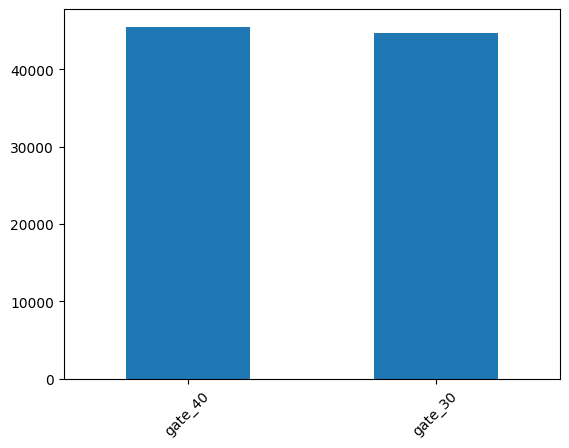

In [8]:
# plot the class balance between control and treatment variable
df['version'].value_counts().plot(kind='bar', rot=45)
plt.show()

In [9]:
# create the pivot table for exploratory plotting
df_pivot = pd.pivot_table(df, values=['sum_gamerounds', 'retention_1', 'retention_7'], index='version', aggfunc=['sum', 'mean', 'median'])
df_pivot

sum                                   mean              \
        retention_1 retention_7 sum_gamerounds retention_1 retention_7   
version                                                                  
gate_30       20034        8502        2344795    0.448188    0.190201   
gate_40       20119        8279        2333530    0.442283    0.182000   

                            median                             
        sum_gamerounds retention_1 retention_7 sum_gamerounds  
version                                                        
gate_30      52.456264         0.0         0.0             17  
gate_40      51.298776         0.0         0.0             16

In [10]:
# create function for plotting all the values from pivot table
# then after that we can call this plot function for...

def plot_pivot(df, col):
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    df['sum'][col].plot(kind='bar', rot=45)
    plt.title(f'Total Sum of {col}')

    plt.subplot(1, 3, 2)
    df['mean'][col].plot(kind='bar', rot=45)
    plt.title(f'Mean of Gamerounds {col}')

    plt.subplot(1, 3, 3)
    df['median'][col].plot(kind='bar', rot=45)
    plt.title(f'Median of {col}')

    plt.show()

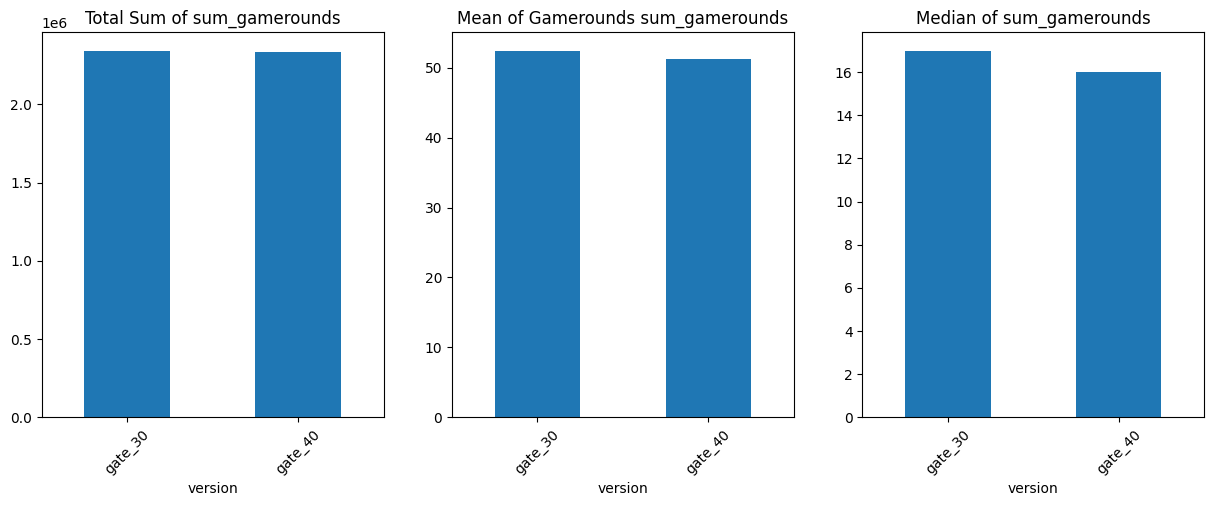

In [11]:
# ... sum_gamerounds
plot_pivot(df_pivot, 'sum_gamerounds')

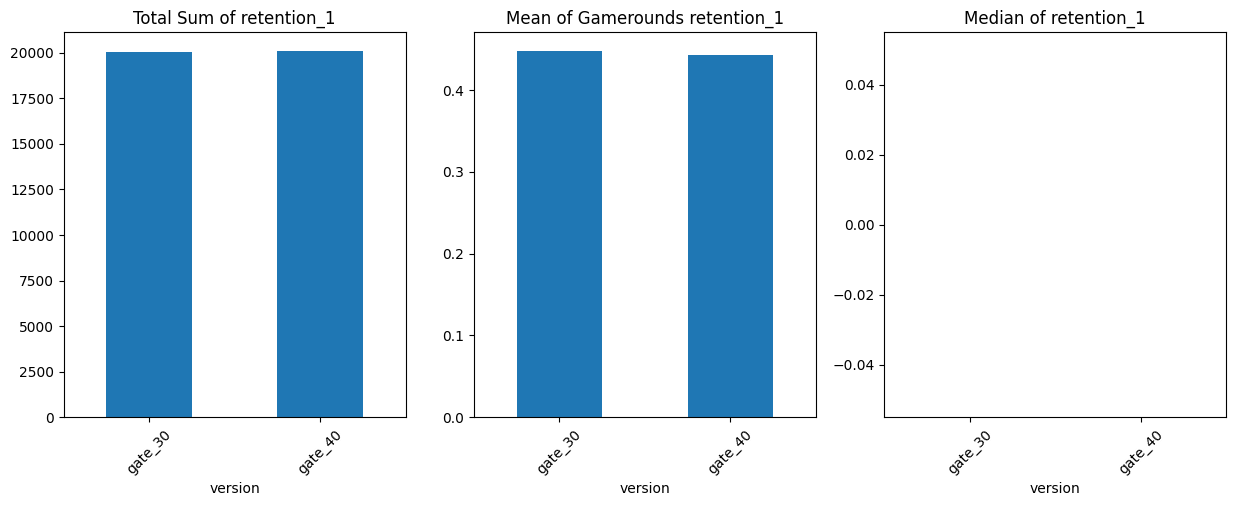

In [12]:
# ... retention_1
plot_pivot(df_pivot, 'retention_1')

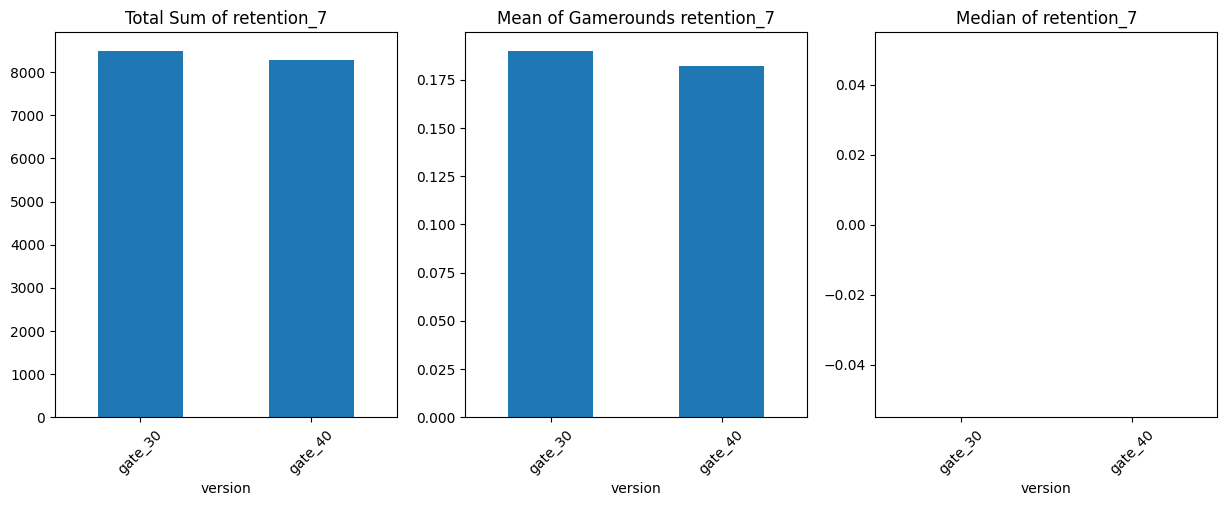

In [13]:
# ... and retention_7
plot_pivot(df_pivot, 'retention_7')

<AxesSubplot: >

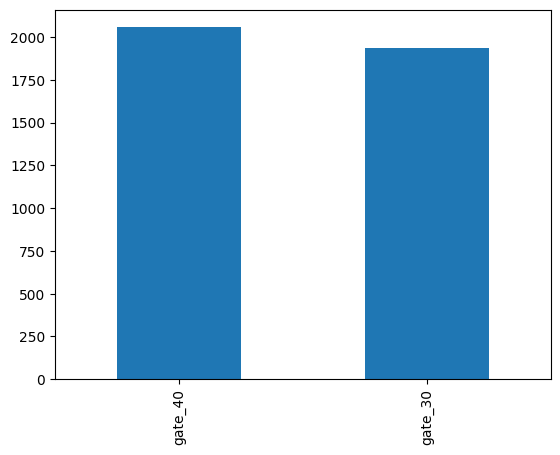

In [14]:
# plot for each version where players didn't come back to play the game
df[df['sum_gamerounds'] == 0]['version'].value_counts().plot(kind='bar', rot=90)

It looks like the treatment by moving the gate to level 40 performs slightly worse than the current gate location we have. But, what does the statistics say?

# 2. Statistical Approach for A/B Testing - Frequentist

## 2.1. Design of the Test

In the design of an A/B experiment, several key steps and considerations are included to ensure the experiment is well-designed and can provide meaningful results. These typically include:

1. **Objective Definition:** Clearly define the objective or goal of the experiment. This helps focus the experiment and ensures that the results will be actionable.

2. **Hypothesis Formulation:** Formulate a hypothesis that you want to test. This includes defining the control and experimental groups and specifying the expected outcome or difference between the groups.

3. **Selection of Variables:** Identify the variables that will be measured in the experiment. These can include both the independent variable (e.g., the variation being tested) and the dependent variables (e.g., the metrics being measured).

4. **Sample Size Calculation:** Calculate the sample size needed for the experiment to ensure that it has enough statistical power to detect the desired effect size.

5. **Randomization:** Randomly assign participants or units to the control and experimental groups to minimize bias and ensure that the groups are comparable.

6. **Data Collection Plan:** Develop a plan for collecting the data needed for the experiment, including the metrics to be measured, the methods of data collection, and the timing of data collection.

7. **Statistical Analysis Plan:** Define the statistical methods that will be used to analyze the data, including the tests that will be used to compare the control and experimental groups and the criteria for determining statistical significance.

8. **Ethical Considerations:** Ensure that the experiment complies with ethical guidelines and respects the rights and privacy of participants.

9. **Risk Assessment:** Identify and assess potential risks associated with the experiment, such as unintended consequences or negative impacts on participants.

10. **Timeline and Budget:** Develop a timeline and budget for the experiment, including key milestones and resources needed.

This notebook will only explain about sample size calculation, as it's the most important one in the case of designing experimentation.

###  2.1.1. Determining sample size

To calculate the sample size for the A/B test, we have to determine first the numbers of:

- **Minimum Detectable Effect (MDE)** (effect size $\delta$): Magnitude of the difference or relationship between two variables in a population
- Desired **statistical power**: The ability of a statistical test to detect a true difference or effect if it exists (ability to avoid false negative).
- Significance level ($\alpha$)
- Variability in the data (usually represented by the standard deviation $\sigma$)

The formula for **one sample** is...

$n = (\frac{Z_{1-\alpha/2} + Z_{1-\beta}}{ES})^2$

while for **two sample**, it is...

$n = 2(\frac{Z_{1-\alpha/2} + Z_{1-\beta}}{ES})^2$

Where ES is Effect size. How to calculate effect size? For **continuous variable**, it is...

$ES = \frac{|\mu_1 - \mu_2|}{\sigma}$

while for **dichotomous variable**, it is...

$ES = \frac{|p_2 - p_1|}{\sqrt{p_1-(1-p_1)}}$

Then, you can plug-and-play the formula in these all situations:

- Sample size for one sample, dichotomous outcome
- Sample sizes for two independent samples, continuous outcome
- Sample size for matched samples, continuous outcome
- Sample sizes for two independent samples, dichotomous outcomes (usually in the case where we've determined **MDE***, baseline conversion rate, and desired lift in conversion rate (effect size))

*Notes: **MDE** refers to the smallest difference between the control and treatment groups that you want to be able to detect with a certain level of confidence and power.

You can check it out here in this <a href="https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_power/bs704_power_print.html#:~:text=Power%20is%20defined%20as%201,outcome%20and%20the%20effect%20size.">link</a>. I'll wrap up everything by putting it into the code below.

In [15]:
import math
import scipy.stats as stats


class SamplePowerAnalysis:
    '''
    Calculate the sample size needed for hypothesis tests based on effect size, power, alpha, and standard deviation.

    Attributes
    -----
    mu1 : float
        Mean before. For dichotomous variables, pass the null hypothesis proportion (p1).
    mu2 : float
        Mean after.
    mud : float
        Difference of means (mu2 - mu1). For dichotomous variables, pass the lift percentage (p2-p1).
    std_dev : float
        Standard deviation.
    alpha : float
        Level of statistical significance.
    power : float
        Level of statistical power.
    '''
    
    def __init__(self, mu1=None, mu2=None, mud=None, std_dev=None, alpha=0.05, power=0.8, one_sided=False):
        self.mu1 = mu1
        self.mu2 = mu2
        self.std_dev = std_dev

        self.z_power = stats.norm.ppf(power)

        if one_sided == False:
            self.z_alpha = stats.norm.ppf(1 - alpha/2)
        else:
            self.z_alpha = stats.norm.ppf(1 - alpha)

        if mud is None:
            self.mud = mu2 - mu1
        else:
            self.mud = mud


    @staticmethod
    def one_sample_n(z_alpha, z_power, effect_size):
        '''
        Calculate the sample size for a one-sample test.

        Parameters
        -----
        z_alpha : float
            Z-score corresponding to the desired significance level.
        z_power : float
            Z-score corresponding to the desired power.
        effect_size : float
            The desired effect size.

        Returns
        -----
        n : float
            The calculated sample size.
        '''
        n = ((z_alpha + z_power) / effect_size) ** 2
        return n

    @staticmethod
    def two_sample_n(z_alpha, z_power, effect_size):
        '''
        Calculate the sample size for a two-sample test.

        Parameters
        -----
        z_alpha : float
            Z-score corresponding to the desired significance level.
        z_power : float
            Z-score corresponding to the desired power.
        effect_size : float
            The desired effect size.

        Returns
        -----
        n : float
            The calculated sample size.
        '''
        n = 2 * ((z_alpha + z_power) / effect_size) ** 2
        return n


    # CONTINUOUS OUTCOME / VARIABLE

    def onesample_con(self):
        '''
        Calculate the sample size for a one-sample test with a continuous variable.
        '''
        mud = self.mud
        std_dev = self.std_dev
        z_alpha = self.z_alpha
        z_power = self.z_power

        effect_size = abs(mud) / std_dev
        n = self.one_sample_n(z_alpha, z_power, effect_size)

        return n

    def twosample_con(self):
        '''
        Calculate the sample size for a two-sample test with a continuous variable.
        '''
        mud = self.mud
        std_dev = self.std_dev
        z_alpha = self.z_alpha
        z_power = self.z_power

        effect_size = mud / std_dev
        n = self.two_sample_n(z_alpha, z_power, effect_size)

        return n

    def matchsample_con(self):
        '''
        Calculate the sample size for a matched-sample test with a continuous variable.
        '''
        mud = self.mud
        std_dev = self.std_dev
        z_alpha = self.z_alpha
        z_power = self.z_power

        effect_size = mud / std_dev
        n = self.one_sample_n(z_alpha, z_power, effect_size)

        return n


    # DICHOTOMOUS OUTCOME / VARIABLE

    def onesample_dic(self):
        '''
        Calculate the sample size for a one-sample test with a dichotomous variable.
        '''
        p1 = self.mu1
        pd = self.mud
        z_alpha = self.z_alpha
        z_power = self.z_power

        effect_size = abs(pd) / math.sqrt(p1 * (1 - p1))
        n = self.one_sample_n(z_alpha, z_power, effect_size)

        return n

    def twosample_dic(self):
        '''
        Calculate the sample size for a two-sample test with a dichotomous variable.
        '''
        p1 = self.mu1
        pd = self.mud
        z_alpha = self.z_alpha
        z_power = self.z_power

        effect_size = abs(pd) / math.sqrt(p1 * (1 - p1))
        n = self.two_sample_n(z_alpha, z_power, effect_size)

        return n

**Sample Size for One Sample, Continuous Outcome**

An investigator hypothesizes that in people free of diabetes, fasting blood glucose, a risk factor for coronary heart disease, is higher in those who drink at least 2 cups of coffee per day. A cross-sectional study is planned to assess the mean fasting blood glucose levels in people who drink at least two cups of coffee per day. 
- The mean fasting blood glucose level in people free of diabetes is reported as 95.0 mg/dL with a standard deviation of 9.8 mg/dL.7 
- If the mean blood glucose level in people who drink at least 2 cups of coffee per day is 100 mg/dL, this would be important clinically. 
- How many patients should be enrolled in the study to ensure that the power of the test is 80% to detect this difference? A two sided test will be used with a 5% level of significance.  

In [16]:
mu1 = 100
mu2 = 95
std_dev = 9.8
alpha = 0.8
power = 0.8

power_analysis = SamplePowerAnalysis(mu1=mu1, mu2=mu2, std_dev=std_dev)
power_analysis.onesample_con()

30.152256387475454

**Sample Sizes for Two Independent Samples, Continuous Outcome**

An investigator is planning a clinical trial to evaluate the efficacy of a new drug designed to reduce systolic blood pressure. The plan is to enroll participants and to randomly assign them to receive either the new drug or a placebo. Systolic blood pressures will be measured in each participant after 12 weeks on the assigned treatment. Based on prior experience with similar trials, the investigator expects that 10% of all participants will be lost to follow up or will drop out of the study. 
- If the new drug shows a 5 unit reduction in mean systolic blood pressure, this would represent a clinically meaningful reduction. 
- How many patients should be enrolled in the trial to ensure that the power of the test is 80% to detect this difference? A two sided test will be used with a 5% level of significance.  
- In order to compute the effect size, an estimate of the variability in systolic blood pressures is needed. 
- Analysis of data from the Framingham Heart Study showed that the standard deviation of systolic blood pressure was 19.0. 

In [17]:
mud = 5
std_dev = 19.0
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mud=mud, std_dev=std_dev, alpha=alpha, power=power)
power_analysis.twosample_con()

226.6756467280017

**Sample Size for Matched Samples, Continuous Outcome**

An investigator hypothesizes that in people free of diabetes, fasting blood glucose, a risk factor for coronary heart disease, is higher in those who drink at least 2 cups of coffee per day. A cross-sectional study is planned to assess the mean fasting blood glucose levels in people who drink at least two cups of coffee per day. 
- The mean fasting blood glucose level in people free of diabetes is reported as 95.0 mg/dL with a standard deviation of 9.8 mg/dL.7 
- If the mean blood glucose level in people who drink at least 2 cups of coffee per day is 100 mg/dL, this would be important clinically. 
- How many patients should be enrolled in the study to ensure that the power of the test is 80% to detect this difference? A two sided test will be used with a 5% level of significance.  

In [18]:
mud = 10
std_dev = 20
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mud=mud, std_dev=std_dev, alpha=alpha, power=power)
power_analysis.matchsample_con()

31.395518937396353

**Sample Size for One Sample, Dichotomous Outcome**


A recent report from the Framingham Heart Study indicated that 26% of people free of cardiovascular disease had elevated LDL cholesterol levels, defined as LDL > 159 mg/dL.9 An investigator hypothesizes that a higher proportion of patients with a history of cardiovascular disease will have elevated LDL cholesterol. How many patients should be studied to ensure that...

- The power of the test is 90% 
- To detect a 5% difference in the proportion with elevated LDL cholesterol? 
- 26% of people free of cardiovascular disease had elevated LDL cholesterol levels
- A two sided test will be used with a 5% level of significance.  

In [19]:
p1 = 0.26
pdiff = 0.05
alpha = 0.05
power = 0.9

power_analysis = SamplePowerAnalysis(mu1=p1, mud=pdiff, alpha=alpha, power=power)
power_analysis.onesample_dic()

808.65127880847

**Sample Sizes for Two Independent Samples, Dichotomous Outcomes**

In this scenario, you are developing a mobile banking app and wish to test a new page to potentially increase user registration rates (conversion rate). To determine the minimum sample size needed per variation for the test, considering the following information:

- Desired Minimum Detectable Effect (MDE or effect size): 10%
- (Baseline) Current conversion rate: 30%
- Desired statistical power: 80%
- Type of test: Two-sided test
- Significance level: 5%

You want to know the minimum sample size required for each variation to detect a 10% improvement in conversion rate with 80% power and a 5% significance level in a two-sided test.

In [20]:
p1 = 0.3
pdiff = 0.1
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mu1=p1, mud=pdiff, alpha=alpha, power=power)
power_analysis.twosample_dic()

329.6529488426617

### 2.1.2 Sample Size for Mobile Gaming

Before conducting the experiment, we aim to determine the minimum sample size needed for our A/B test. We are interested in measuring the difference in total gamerounds, retention_1, and retention_7. Based on our mobile game data, the current baseline values are as follows:

- Current gamerounds mean (baseline): 52.46
- Current gamerounds standard deviation (baseline): 256.72
- Current retention_1 rate (baseline): 45%
- Current retention_7 rate (baseline): 19%

We aim for a statistical power of 80% and set the significance level at 5%.

In [21]:
# calculation for the previous one

gameround_base = df[df['version'] == 'gate_30']['sum_gamerounds'].mean()
gameround_std = df[df['version'] == 'gate_30']['sum_gamerounds'].std()

ret1_base = df[df['version'] == 'gate_30']['retention_1'].mean()
ret7_base = df[df['version'] == 'gate_30']['retention_7'].mean()

print(f'all the values results are {gameround_base}, {gameround_std}, {ret1_base}, {ret7_base}')

all the values results are 52.45626398210291, 256.71642311604455, 0.4481879194630872, 0.19020134228187918


In [22]:
# two sample continuous

mud = 5                     # we want to see 5 gamerounds difference in mean
std_dev = gameround_std     # pass the value from the previous code
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mud=mud, std_dev=std_dev, alpha=alpha, power=power)
n_games = math.ceil(power_analysis.twosample_con())
print('minimum of sample size per group is:', n_games)

minimum of sample size per group is: 41382


In [23]:
# two sample dichotomous

p1 = ret1_base      # pass the baseline here from the previous one
pd = 0.01           # we want to see 1% difference
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mu1=p1, mud=pd, alpha=alpha, power=power)
n_ret1 = math.ceil(power_analysis.twosample_dic())
print('minimum of sample size per group is:', n_ret1)

minimum of sample size per group is: 38823


In [24]:
# two sample dichotomous

p1 = ret7_base      # pass the baseline here from the previous one
pdiff = 0.01        # we want to see 1% difference
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mu1=p1, mud=pdiff, alpha=alpha, power=power)
n_ret2 = math.ceil(power_analysis.twosample_dic())
print('minimum of sample size per group is:', n_ret2)

minimum of sample size per group is: 24179


# 2.2. Statistical Test

Once we have gathered the data according to the required minimum sample size, we can proceed with the data analysis using statistical tests. In this mobile game scenario, we will be using specifically **comparison tests**. Comparison tests is a group of test to compare differences among group, depending on the variables involved. The following list presents the tests available for conducting the statistical analysis, sourced from <a href='https://www.scribbr.com/statistics/statistical-tests/'>Scribbr.</a> There are two types of test that this notebook will focus on: **parametric vs. non-parametric test**.

<img src="images/flowchart-for-choosing-a-statistical-test.png" alt="parametric" width="1000"/>

### 2.2.1. Parametric vs. Non-parametric test

Parametric and non-parametric tests are two broad categories of statistical tests used to analyze data, but they differ in their assumptions and the types of data they are suitable for.

1. **Parametric Tests:**
   - **Assumption:** Parametric tests assume that the data are drawn from a population that follows a specific probability distribution, usually the normal distribution.
   - **Data Type:** Parametric tests are typically used for continuous data that are normally distributed or can be transformed to approximate a normal distribution.
   - **Examples:** t-tests, ANOVA, linear regression, Pearson correlation.
   - **Advantages:** Parametric tests are often more powerful (i.e., they can detect smaller effects) when their assumptions are met.

2. **Non-Parametric Tests:**
   - **Assumption:** Non-parametric tests make fewer assumptions about the underlying distribution of the data. They are based on ranks or frequencies rather than the actual data values.
   - **Data Type:** Non-parametric tests are useful for ordinal or categorical data, or when the data do not meet the assumptions of parametric tests.
   - **Examples:** Mann-Whitney U test, Wilcoxon signed-rank test, Kruskal-Wallis test, Spearman correlation.
   - **Advantages:** Non-parametric tests are more robust to violations of assumptions and can be used when the data are skewed or have outliers.

When to Choose Parametric vs. Non-Parametric Tests:
- **Data Distribution:** If your data are normally distributed and meet the assumptions of parametric tests, it is generally preferable to use parametric tests due to their greater statistical power.
- **Data Type:** If your data are ordinal, categorical, or do not meet the assumptions of parametric tests, non-parametric tests may be more appropriate.
- **Robustness:** Non-parametric tests are often preferred when the data are not normally distributed or when the assumptions of parametric tests cannot be met.

Take a look at the tables below taken from Scribbr for the types of statistical tests in both parametric and non-parametric tests.

<img src="images/parametric.png" alt="parametric" width="1000"/>

<img src="images/non-parametric.png" alt="parametric" width="1000"/>

### 2.2.2. Statistical Tests for Gaming Dataset

#### 2.2.2.1 Difference of Sum Gamerounds Using Independent T-Test

In [25]:
# sample the data using the sample size

import numpy as np
import pandas as pd
import scipy.stats as stats


def cohens_d(group1, group2):
    
    mean_diff = np.mean(group1) - np.mean(group2)
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    n1 = len(group1)
    n2 = len(group2)
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    pooled_std = np.sqrt(pooled_var)

    cohens_d = mean_diff / pooled_std

    return cohens_d

# we'll be running this code 30 times to see sampling difference

df_result = pd.DataFrame(columns=['mean_diff', 'es', 't_test', 'p_val', 'sig'])

for i in range(30):

    df_gate30 = df[df['version'] == 'gate_30'].reset_index(drop=True)
    df_gate40 = df[df['version'] == 'gate_40'].reset_index(drop=True)

    df_gate30 = df_gate30.iloc[np.random.randint(0, len(df_gate30), n_games), :]
    df_gate40 = df_gate40.iloc[np.random.randint(0, len(df_gate30), n_games), :]

    # using the independent t-test to test the difference between 

    t_test, p_val = stats.ttest_ind(a=df_gate30['sum_gamerounds'], b=df_gate40['sum_gamerounds'])
    es = cohens_d(df_gate30['sum_gamerounds'], df_gate40['sum_gamerounds'])

    df_result.loc[i, 'mean_diff'] = round((df_gate30['sum_gamerounds'].mean() - df_gate40['sum_gamerounds'].mean()), 3)
    df_result.loc[i, 'es'] = round(es, 3)
    df_result.loc[i, 't_test'] = round(t_test, 3)
    df_result.loc[i, 'p_val'] = round(p_val, 3)


df_result['sig'] = [True if x <= 0.05 else False for x in df_result['p_val']]
df_result = df_result.sort_values('mean_diff', ascending=False)

df_result

,mean_diff,es,t_test,p_val,sig
18,6.087,0.017,2.427,0.015,True
0,4.103,0.015,2.225,0.026,True
17,3.851,0.014,2.085,0.037,True
6,2.945,0.011,1.599,0.11,False
16,2.653,0.008,1.206,0.228,False
8,2.441,0.009,1.324,0.185,False
22,2.255,0.008,1.222,0.222,False
26,2.147,0.011,1.54,0.124,False
15,2.113,0.01,1.507,0.132,False
25,1.837,0.009,1.311,0.19,False


During the sample size determination process, we established a minimum detectable effect of 5 (mean difference) as the threshold for rejecting the null hypothesis. As shown in the table, **we only reject the null hypothesis when the mean difference exceeds 5**. If the mean difference is below 5, we fail to reject the null hypothesis

In addition to that, we found that **we rejected the hypothesis few times**, while they're actually False Positive (Type 1 Error). Why is that? When you set the significance level at 0.05, you are essentially saying **that you are willing to accept a 5% chance of incorrectly rejecting the null hypothesis** (a false positive or Type I error).

In your case, if you conducted 30 tests and obtained 3 significant results, it is possible that these 3 significant results are false positives, occurring by chance due to the 5% significance level. This is why it's important to interpret the results of hypothesis tests with caution, especially when conducting multiple tests, and consider the possibility of false positives when making conclusions based on statistical significance.

#### 2.2.2.2. Difference of Retention Chi-Square Independent Test

**Retention after 1 day**

In [26]:
import numpy as np
import pandas as pd


def odds_ratio(df_cross, control_var, treat_var):

    control = df_cross.loc[True, control_var] / df_cross.loc[False, control_var]
    treatment = df_cross.loc[True, treat_var] / df_cross.loc[False, treat_var]

    odds_ratio = treatment / control

    return round(odds_ratio, 3)

df_result = pd.DataFrame(columns=['lift', 'mean_control', 'mean_treat', 'odds_ratio', 'chi_test', 'p_val', 'sig'])

# sample the data using the sample size
# and again, we'll be running this code 30 times to see sampling difference

for i in range(30):

    df_gate30 = df[df['version'] == 'gate_30'].reset_index(drop=True)
    df_gate40 = df[df['version'] == 'gate_40'].reset_index(drop=True)

    df_gate30 = df_gate30.iloc[np.random.randint(0, len(df_gate30), n_ret1), :]
    df_gate40 = df_gate40.iloc[np.random.randint(0, len(df_gate30), n_ret1), :]

    df_test = pd.concat([df_gate30, df_gate40]).reset_index(drop=True)
    df_cross = pd.crosstab(df_test['version'], df_test['retention_1']).T

    # using the chi-square test to test the independence of the two categorical variables
    
    chi_test, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_test['version'], df_test['retention_1']))

    df_result.loc[i, 'lift'] = round((df_gate40['retention_1'].mean() - df_gate30['retention_1'].mean()) * 100, 3)
    df_result.loc[i, 'mean_control'] = round(df_gate30['retention_1'].mean(), 3)
    df_result.loc[i, 'mean_treat'] = round(df_gate40['retention_1'].mean(), 3)
    df_result.loc[i, 'odds_ratio'] = odds_ratio(df_cross, 'gate_30', 'gate_40')
    df_result.loc[i, 'chi_test'] = round(chi_test, 3)
    df_result.loc[i, 'p_val'] = round(p_val, 3)

    df_result['sig'] = [True if x <= 0.05 else False for x in df_result['p_val']]
    df_result = df_result.sort_values('p_val')

df_result

,lift,mean_control,mean_treat,odds_ratio,chi_test,p_val,sig
12,-1.136,0.45,0.439,0.955,10.097,0.001,True
28,-1.002,0.451,0.441,0.96,7.848,0.005,True
25,-0.912,0.451,0.442,0.964,6.492,0.011,True
29,-0.868,0.453,0.445,0.966,5.877,0.015,True
3,-0.827,0.448,0.44,0.967,5.342,0.021,True
10,-0.773,0.448,0.441,0.969,4.663,0.031,True
1,-0.742,0.448,0.441,0.97,4.297,0.038,True
13,-0.719,0.45,0.442,0.971,4.028,0.045,True
8,-0.716,0.452,0.444,0.971,3.996,0.046,True
15,-0.68,0.452,0.445,0.973,3.602,0.058,False


**Retention after 7-day**

In [27]:
df_result = pd.DataFrame(columns=['lift', 'mean_control', 'mean_treat', 'odds_ratio', 'chi_test', 'p_val', 'sig'])

# sample the data using the sample size
# and again, we'll be running this code 30 times to see sampling difference

for i in range(30):

    df_gate30 = df[df['version'] == 'gate_30'].reset_index(drop=True)
    df_gate40 = df[df['version'] == 'gate_40'].reset_index(drop=True)

    df_gate30 = df_gate30.iloc[np.random.randint(0, len(df_gate30), n_ret2), :]
    df_gate40 = df_gate40.iloc[np.random.randint(0, len(df_gate30), n_ret2), :]

    df_test = pd.concat([df_gate30, df_gate40]).reset_index(drop=True)
    df_cross = pd.crosstab(df_test['version'], df_test['retention_7']).T

    # using the chi-square test to test the independence of the two categorical variables
    
    chi_test, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_test['version'], df_test['retention_7']))

    df_result.loc[i, 'lift'] = round((df_gate40['retention_7'].mean() - df_gate30['retention_7'].mean()) * 100, 3)
    df_result.loc[i, 'mean_control'] = round(df_gate30['retention_7'].mean(), 3)
    df_result.loc[i, 'mean_treat'] = round(df_gate40['retention_7'].mean(), 3)
    df_result.loc[i, 'odds_ratio'] = odds_ratio(df_cross, 'gate_30', 'gate_40')
    df_result.loc[i, 'chi_test'] = round(chi_test, 3)
    df_result.loc[i, 'p_val'] = round(p_val, 3)

    df_result['sig'] = [True if x <= 0.05 else False for x in df_result['p_val']]
    df_result = df_result.sort_values('p_val')

df_result

,lift,mean_control,mean_treat,odds_ratio,chi_test,p_val,sig
13,-1.278,0.191,0.179,0.919,13.005,0.0,True
19,-1.559,0.196,0.181,0.903,19.097,0.0,True
28,-1.559,0.194,0.179,0.902,19.256,0.0,True
15,-1.336,0.194,0.18,0.916,14.101,0.0,True
22,-1.328,0.19,0.177,0.915,14.146,0.0,True
5,-1.137,0.194,0.183,0.928,10.143,0.001,True
1,-1.17,0.189,0.177,0.925,11.009,0.001,True
27,-1.204,0.19,0.178,0.923,11.592,0.001,True
6,-1.195,0.193,0.181,0.924,11.282,0.001,True
16,-1.212,0.19,0.178,0.923,11.732,0.001,True


In the process of determining the sample size, we defined a minimum detectable effect (MDE) of a 1% increase as the point at which we would reject the null hypothesis. As illustrated in the table, **we reject the null hypothesis when the increase is near 1%.** If the increase deviates significantly from 1%, we do not reject the null hypothesis.

This highlights the significance of aligning the sample size with the test for differences that we are conducting. Next, we will explore the possibility of reducing the sample size even further and see what happen with the result.

#### 2.2.2.3. Sampling Size Effect on the Test Result

In [28]:
n_sample = 1000
df_result = pd.DataFrame(columns=['lift', 'mean_control', 'mean_treat', 'odds_ratio', 'chi_test', 'p_val', 'sig'])

# sample the data using the sample size
# and again, we'll be running this code 30 times to see sampling difference

for i in range(30):

    df_gate30 = df[df['version'] == 'gate_30'].reset_index(drop=True)
    df_gate40 = df[df['version'] == 'gate_40'].reset_index(drop=True)

    df_gate30 = df_gate30.iloc[np.random.randint(0, len(df_gate30), n_sample), :]
    df_gate40 = df_gate40.iloc[np.random.randint(0, len(df_gate30), n_sample), :]

    df_test = pd.concat([df_gate30, df_gate40]).reset_index(drop=True)
    df_cross = pd.crosstab(df_test['version'], df_test['retention_1']).T

    # using the chi-square test to test the independence of the two categorical variables
    
    chi_test, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_test['version'], df_test['retention_1']))

    df_result.loc[i, 'lift'] = round((df_gate40['retention_1'].mean() - df_gate30['retention_1'].mean()) * 100, 3)
    df_result.loc[i, 'mean_control'] = round(df_gate30['retention_1'].mean(), 3)
    df_result.loc[i, 'mean_treat'] = round(df_gate40['retention_1'].mean(), 3)
    df_result.loc[i, 'odds_ratio'] = odds_ratio(df_cross, 'gate_30', 'gate_40')
    df_result.loc[i, 'chi_test'] = round(chi_test, 3)
    df_result.loc[i, 'p_val'] = round(p_val, 3)

    df_result['sig'] = [True if x <= 0.05 else False for x in df_result['p_val']]
    df_result = df_result.sort_values('p_val')

df_result

,lift,mean_control,mean_treat,odds_ratio,chi_test,p_val,sig
21,-9.2,0.467,0.375,0.685,16.986,0.0,True
12,-7.1,0.476,0.405,0.749,9.941,0.002,True
2,-6.7,0.482,0.415,0.762,8.805,0.003,True
0,-6.2,0.46,0.398,0.776,7.595,0.006,True
6,-5.2,0.448,0.396,0.808,5.332,0.021,True
1,-5.0,0.463,0.413,0.816,4.877,0.027,True
9,-4.8,0.458,0.41,0.822,4.496,0.034,True
18,-4.7,0.468,0.421,0.827,4.285,0.038,True
19,-4.7,0.472,0.425,0.827,4.277,0.039,True
7,-4.0,0.431,0.391,0.848,3.142,0.076,False


In [29]:
# two sample dichotomous

p1 = ret7_base      # pass the baseline here from the previous one
pd = 0.05           # now check with 5%
alpha = 0.05
power = 0.8

power_analysis = SamplePowerAnalysis(mu1=p1, mud=pd, alpha=alpha, power=power)
n_ret2 = math.ceil(power_analysis.twosample_dic())
print('minimum of sample size per group is:', n_ret2)

minimum of sample size per group is: 968


As you can see on the table above, we now started to reject the null hyptohesis when the lift is close to 5%. After we did the power analysis, we found again with MDE at 5%, the required sample is at 968. Based on the power analysis results we did, our observations are consistent with the expected behavior of statistical power and effect size:

* **MDE 5%**: Requiring a smaller sample size (1000) aligns with the expected behavior. With a **larger effect size (MDE 5%)**, it's easier to detect the difference even with a **limited sample size**, leading to less data needed to achieve the desired power (0.8).
* **MDE 1%**: Needing a larger sample size (30,000) also aligns with expectations. A **smaller effect size (MDE 1%)** requires a **larger sample** (30,000) to overcome the inherent variability in the data.

Therefore, the power analysis results **correctly reflect** the relationship between **MDE and sample size**. The scenario demonstrates how **larger sample sizes are necessary to detect smaller effects** while maintaining the desired level of **statistical power**.

# 2.3. Conclusion

The experiment that I ran before was the best scenarion when we have a previlege to run the experiment multiple of times. But, we still found out that from all experiments, few experiments turned out to show different result with the rest of the others. In a single experiment, **even with a well-designed study and sufficient power based on your analysis, there's still a chance of encountering a false positive**. This is due to the inherent randomness in sampling and the specific realization of the data you collect.

Thus, what can we do to mitigate all of this?

1. Acknowledge the Limitations
2. Consider Additional Evidence
3. Focus on the Magnitude of the Effect 
4. Be Transparent about the Uncertainty

# 3. Statistical Approach for A/B Testing - Bayesian

## 3.1. Theory of Bayesian Statistics

There's a different approach on how to tackle statistical test, especially in A/B testing; Bayesian approach. What's the difference?

- **Frequentist Approach:** This approach sees probability as the long-term frequency of an event occurring if we were to repeat an experiment infinitely. In other words, it focuses on the probability of the data given a fixed, but unknown, true value of the parameter. It does not assign probabilities to hypotheses or parameters. For example, if you toss a coin many times, the frequentist approach focuses on the proportion of times it comes up heads.

- **Bayesian Approach:** In contrast, Bayesian approach treats probability as a measure of the degree of belief or certainty in an event. It incorporates prior beliefs about the likelihood of different values of a parameter and updates these beliefs based on the observed data, using Bayes' theorem. This means it can assign probabilities to hypotheses or parameters directly. For example, if you have a hunch about the likelihood of something, you can use Bayesian methods to update your belief with new information.

The formula itself comes from conditional probability theory, but we can write it like this:

$P(\theta|Data) = \frac{P(Data|\theta) * P(\theta)}{P(Data)}$

where...

1. **Prior** $P(\theta)$:
   - **Definition:** The prior represents your initial belief about the probability of an event before observing any data.
   - **Example:** Let's say you're trying to diagnose a rare disease, and you know that the overall prevalence of this disease in the population is very low. So, your prior belief might be that the probability of a randomly selected person having the disease is low, say 0.001. 
   
2. **Likelihood** $P(Data|\theta)$:
   - **Definition:** The likelihood represents the probability of observing the data given a specific hypothesis or parameter value.
   - **Example:** If the test for the disease is 99% accurate (i.e., the likelihood of a positive test result given that the person has the disease is 0.99), and the likelihood of a negative test result given that the person does not have the disease is also 99%, then the likelihood of observing a positive test result for a person with the disease is 0.99, and the likelihood of observing a negative test result for a person without the disease is 0.99.

3. **Evidence:** $P(Data)$
   - **Definition:** The evidence represents the total probability of observing the data, considering all possible values of the parameter.
   - **Example:** In our case, the evidence would be the total probability of observing the test result, considering both the scenario where the person has the disease and where the person does not have the disease.

4. **Posterior:** $P(\theta|Data)$
   - **Definition:** The posterior represents the updated belief about the probability of an event after observing the data.
   - **Example:** After observing a positive test result, you can use Bayes' theorem to update your prior belief about the probability of the person having the disease to get the posterior probability, which would reflect your updated belief after considering the test result.

Then we have to understand about the concept of **probability distributions**, where it plays a crucial role in representing uncertainty and updating beliefs. In Bayesian inference, the distributions that we typically need to estimate or specify are the **prior distribution, likelihood function, and posterior distribution.** The evidence, while important for the normalization of the posterior distribution, is often not explicitly estimated or calculated in practice, especially when using computational methods like Markov chain Monte Carlo (MCMC).

- Estimating the prior distribution involves choosing its functional form and parameters.
- Estimating the likelihood function involves specifying its form based on the data and the model.
- Estimating the posterior distribution involves calculating or approximating its shape and parameters based on the prior distribution, likelihood function, and observed data.

Then we have to also understand the concept of conjugate prior.

A **conjugate prior is a prior distribution that, when combined with a specific likelihood function, results in a posterior distribution that is of the same family as the prior distribution.** In other words, the prior and posterior distributions are "conjugate" to each other.

Using a conjugate prior simplifies the calculation of the posterior distribution because the form of the posterior distribution is known analytically. This allows for easier updating of beliefs in Bayesian inference without the need for complex numerical methods.

The pairs are for instance:

- Binomial Likelihood with Beta Conjugate Prior
- Bernoulli Likelihood with Binomial Conjugate Prior:
- Normal Likelihood with Normal Conjugate Prior (Known Variance)
- Normal Likelihood with Normal Conjugate Prior (Unknown Variance)
- Poisson Likelihood with Gamma Conjugate Prior
- Exponential Likelihood with Gamma Conjugate Prior

## 3.2. Example of Doing Bayesian Statistics

### 3.2.1. Retention Rate for Gaming

For retention rate for gaming, we have to determine all the distributions first.

- **Prior distribution:** Beta distribution, flexible distribution that is bounded between 0 and 1, which is suitable for representing probabilities for probability.
- **Likelihood function:** Binomial distribution, it describes the probability of observing a certain number of successes (e.g., purchases) out of a known number of trials (e.g., visitors) given a probability of success (e.g., the conversion rate).
- **Posterior distribution:** Beta distribution, as beta prior conjugate + binomial likelihood = beta distribution

Now, let's put it into formula.

1. **Prior distribution**

$P(p) = Beta(\alpha_{prior}, \beta_{prior})$

...where $\alpha$ and $\beta$ are the shape parameters of the beta distribution representing our prior beliefs. We can also determine the $\alpha$ and $\beta$ as...

$Mean\_prior = \frac{\alpha}{\alpha + \beta}$

If we don't have any information about the prior, we can set it as uniform distribution where $\alpha$ = $\beta$ = 1

2. **Likelihood Function**

$P(Data|p) = \frac{Binomial(n,p)}{P(Data)}$

...where data represents the number of successes $k$ observed in $n$ trials and $p$ is the rate. Since the **marginal likelihood is constant across the groups in this case**, we can **focus on the relative differences** in the posterior distributions without explicitly calculating the marginal likelihood $P(Data)$. Thus, we can eliminate the marginal likelihood to get the formula below:

$P(Data|p) \propto Binomial(n,p)$

3. **Posterior distribution (updated belief)**

Using the properties of the beta distribution and the binomial distribution, the posterior distribution is also a beta distribution with updated parameters. Thus...

$\alpha_{posterior} = \alpha_{prior} + k$ \
$\beta_{posterior} = \beta_{prior} + n - k$

4. **Final formula**

$P(p|Data) \propto Beta(\alpha_{posterior}, \beta_{posterior})$

Let's take it into calculation now.

#### 3.2.1.1. Hard Coding (Analytical)

In [30]:
# sampling the data first

n_prior = 3000

df_prior = df[df['version'] == 'gate_30'].sample(n_prior)            # take some samples for the prior, only for simulation
df_test = df[~df['userid'].isin(df_prior['userid'])]                 # remove all the data we used for the prior sample

# calculate all the data we need for the prior

mean_prior = df_prior['retention_1'].mean()                          # calculate the mean for the prior
alpha_prior = 100                                                     # we can adjust alpha to let's say 2, 5, or 10, and beta will adjust
beta_prior = (alpha_prior - mean_prior * alpha_prior) / mean_prior   # a little algebra to know the formula for finding beta given alpha and mean

In [31]:
from scipy.stats import beta, binom

# data for control

n_control = len(df_test[df_test['version'] == 'gate_30'])                                       # number of control sample
k_control = len(df_test[(df_test['version'] == 'gate_30') & (df_test['retention_1'] == True)])  # number of people who're still playing the game after 1 day

n_treat = len(df_test[df_test['version'] == 'gate_40'])
k_treat = len(df_test[(df_test['version'] == 'gate_40') & (df_test['retention_1'] == True)]) 

# start modeling the data

alpha_post_treat = alpha_prior + k_treat 
beta_post_treat = beta_prior + n_treat - k_treat

alpha_post_control = alpha_prior + k_control
beta_post_control = beta_prior + n_control - k_control

# generate the posterior

post_treat = beta(alpha_post_treat, beta_post_treat)
post_control = beta(alpha_post_control, beta_post_control)

# the previous lines of code might be expensive to compute if the model is much more complex
# furthermore, if we're not using a conjugate prior distribution for the prior, it would be impossible to calculate analitically
# so, we can use codes below by sampling the posterior instead

'''UNCOMMENT THE CODE BELOW'''
# post_treat = beta.rvs(alpha_post_treat, beta_post_treat, size=100000)
# post_control = beta.rvs(alpha_post_control, beta_post_control, size=10000)

'UNCOMMENT THE CODE BELOW'

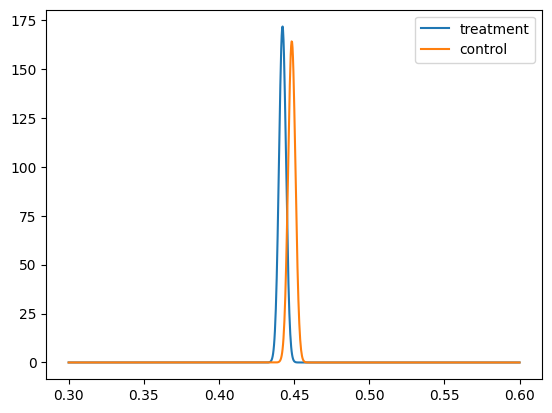

Probability that treatment is better than control: -0.006173882053222168


In [32]:
# plot and calculate the result

import matplotlib.pyplot as plt

x = np.linspace(0.3, 0.6, 1000)                        # in beta distribution, it should be 0-1. but we scale it down to be able to look into the graph in more details
plt.plot(x, post_treat.pdf(x), label='treatment')      # plot the graph for treatment
plt.plot(x, post_control.pdf(x), label='control')       # plot the graph for control
plt.legend()
plt.show()

diff_rate = post_treat.mean() - post_control.mean()
print("Probability that treatment is better than control:", diff_rate)

#### 3.2.1.1. Using PyMC library (Numerical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_treat, prior_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


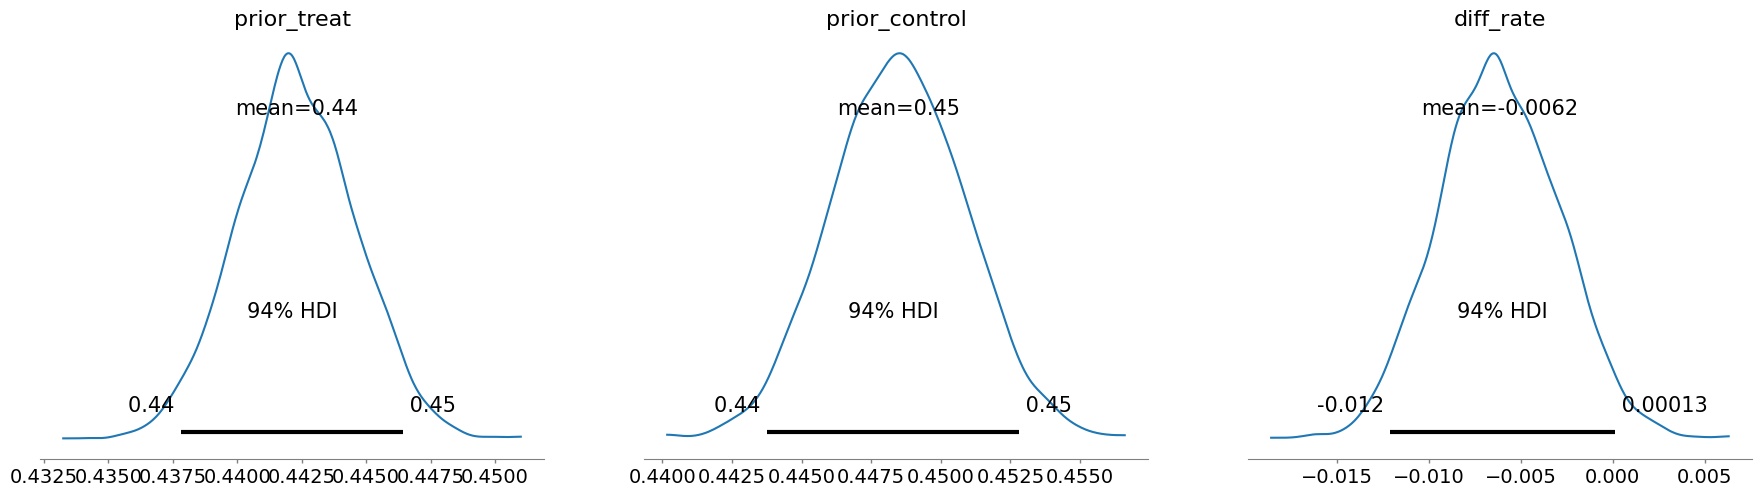

In [57]:
import pymc as pm

with pm.Model() as model:
    # prior distribution for the rate
    prior_treat = pm.Beta('prior_treat', alpha=alpha_prior, beta=beta_prior)
    prior_control = pm.Beta('prior_control', alpha=alpha_prior, beta=beta_prior)

    # likelihood function using binomial distribution
    likelihood_treat = pm.Binomial('likelihood_treat', n=n_treat, p=prior_treat, observed=k_treat)
    likelihood_control = pm.Binomial('likelihood_control', n=n_control, p=prior_control, observed=k_control)

    # compute the difference in rate
    # deterministic nodes are only deterministic given all of their inputs, i.e. they don’t add randomness to the model. 
    # they are generally used to record an intermediary result.
    diff_rate = pm.Deterministic('diff_rate', prior_treat - prior_control)

    # sample from posterior distribution
    trace = pm.sample(1000, tune=1000)

pm.plot_posterior(trace.posterior)
plt.show()

### 3.2.2. Sum of Gamerounds - Poisson Prior

Moving on to comparing the game rounds between the control and treatment groups. Let's say we want to **compare the mean of sum of gamerounds**. We need to determine the distribution:

- **Prior distribution:** Normal prior, commonly used as a prior for the mean difference because it is a conjugate prior for the normal likelihood function.
- **Likelihood function:** Normal likelihood, commonly used as the likelihood function for continuous data because it is mathematically convenient and often a good approximation for many real-world datasets.
- **Posterior distribution:** Normal posterior, as normal prior + normal likelihood = normal posterior.

Now, we'll go with the poisson prior. Then, we'll go with the normal prior. Let's put this into the action:

1. **Prior distribution**

- $\text{Prior for mean difference (\( \mu \)): } \mu \sim N(\mu_0, \sigma_0^2)$ \
- $\text{Prior for precision (\( \tau \)): } \tau \sim \text{Gamma}(a, b)$

Wait, **what is precision**? In Bayesian statistics, the precision is the inverse of the variance of a distribution. It is often used instead of the variance because it has some computational advantages, especially when dealing with normal distributions.

The precision prior, denoted as ($\tau$), can be modeled using a gamma distribution, which is a conjugate prior for the precision parameter of a normal distribution. The gamma distribution has two parameters, ($a$) and ($b$), which can be chosen based on prior knowledge or beliefs about the precision.

In Bayesian statistics, the precision is the inverse of the variance of a distribution. It is often used instead of the variance because it has some computational advantages, especially when dealing with normal distributions.

The probability density function (pdf) of the gamma distribution is given by:

- $p(\tau) = \frac{b^a}{\Gamma(a)} \tau^{a-1} e^{-b\tau}$

where $\Gamma(a)$ is the gamma function.

Using a gamma prior for the precision in a Bayesian t-test allows us to **incorporate prior beliefs about the variability of the data** into the analysis.

2. **Likelihood function**

- $\text{Likelihood function for each group: }p(x_i | \mu, \tau) = \left( \frac{\tau}{2\pi} \right)^{1/2} \exp \left( -\frac{\tau}{2} (x_i - \mu)^2 \right)$

where ($x_i$) is the data point for group ($i$), ($mu$) is the mean, and ($\tau$) is the precision (inverse variance).

3. **Posterior distribution**

- $\text{Posterior for mean difference (\( \mu \)): } p(\mu | x) \propto p(x | \mu, \tau) \times p(\mu)$
- $\text{Posterior for precision (\( \tau \)): } p(\tau | x) \propto p(x | \mu, \tau) \times p(\tau)$

Thus, plugging in all the formulas, we can calculate the posterior distribution as follow:

- $\text{Posterior mean for \( \mu \): } \frac{\sum_{i=1}^{n} \tau x_i + \tau_0 \mu_0}{\sum_{i=1}^{n} \tau + \tau_0}$
- $\text{Posterior variance for \( \mu \): } \frac{1}{\sum_{i=1}^{n} \tau + \tau_0}$
- $\text{Posterior parameters for \( \tau \): } a' = a + \frac{n}{2}, b' = b + \frac{1}{2} \sum_{i=1}^{n} (x_i - \mu)^2 + \frac{n \tau_0 (\mu - \mu_0)^2}{2 (\tau + \tau_0)}$

Yes, it's very complex. Now, we'll do the calculation using both hard coding and pymc library.

In [227]:
# sampling the data first to simulate the A/B test
# simulate that we have prior of sum of game rounds of 40000

n_prior = math.floor(len(df[df['version'] == 'gate_30']) / 2)

df_prior = df[df['version'] == 'gate_30'].sample(n_prior)                                       # take some samples for the prior, only for simulation

df_test_control = df[(~df['userid'].isin(df_prior['userid'])) & (df['version'] == 'gate_30')]   # now after conducting the a/b testing, for control group
df_test_treat = df[df['version'] == 'gate_40'].sample(n_prior)                                  # now after conducting the a/b testing, for treatment group

# calculate all the data we need for the prior

prior_mu = df_prior['sum_gamerounds'].mean()
prior_std_dev = df_prior['sum_gamerounds'].std()

# calculate the observed data both for treatment and control

data_treat = df_test_treat['sum_gamerounds'].values
data_control = df_test_control['sum_gamerounds'].values

#### 3.2.1.1. Hard Coding (Analytical)

In [245]:
import numpy as np

# likelihood for treatment and control groups
likelihood_treat = np.exp(-0.5 * ((data_treat - prior_mu) / prior_std_dev) ** 2)
likelihood_control = np.exp(-0.5 * ((data_control - prior_mu) / prior_std_dev) ** 2)

# posterior mean and standard deviation for treatment group
posterior_std_dev_treat = 1 / np.sqrt(1 / prior_std_dev ** 2 + len(data_treat) / prior_std_dev ** 2)
posterior_mu_treat = (prior_mu / prior_std_dev ** 2 + data_treat.sum() / prior_std_dev ** 2) / (1 / prior_std_dev ** 2 + len(data_treat) / prior_std_dev ** 2)

# posterior mean and standard deviation for control group
posterior_std_dev_control = 1 / np.sqrt(1 / prior_std_dev ** 2 + len(data_control) / prior_std_dev ** 2)
posterior_mu_control = (prior_mu / prior_std_dev ** 2 + data_control.sum() / prior_std_dev ** 2) / (1 / prior_std_dev ** 2 + len(data_control) / prior_std_dev ** 2)

# difference in means
diff_mean = posterior_mu_treat - posterior_mu_control

# given that the posterior distribution is normal, we can calculate the 95% credible interval using the standard formula
ci_lower = diff_mean - 1.96 * np.sqrt(posterior_std_dev_treat ** 2 + posterior_std_dev_control ** 2)
ci_upper = diff_mean + 1.96 * np.sqrt(posterior_std_dev_treat ** 2 + posterior_std_dev_control ** 2)

print("Difference in means posterior mean:", round(diff_mean, 3))
print("Difference in means 95% credible interval:", round(ci_lower, 3), 'to', round(ci_upper, 3))

Difference in means posterior mean: -2.084
Difference in means 95% credible interval: -3.923 to -0.245


#### 3.2.1.2. Using pymc Library (Numerical)

In [230]:
import pymc as pm

# modeling the distribution for prior, likelihood, and posterior

with pm.Model() as model:
    # prior for treatment and control group
    mu_treat = pm.Normal('mu_treat', mu=prior_mu, sigma=prior_std_dev) 
    mu_control = pm.Normal('mu_control', mu=prior_mu, sigma=prior_std_dev) 

    # calculate the likelihood
    likelihood_treat = pm.Normal('likelihood_treat', mu=mu_treat, sigma=prior_std_dev, observed=data_treat)
    likelihood_control = pm.Normal('likelihood_control', mu=mu_control, sigma=prior_std_dev, observed=data_control)

    # calculate the difference in means
    diff_mean = pm.Deterministic('diff_mean', mu_treat - mu_control)

    # sample from posterior
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treat, mu_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Difference in means posterior mean: -2.11
Difference in means 95% credible interval: -3.932 to -0.306


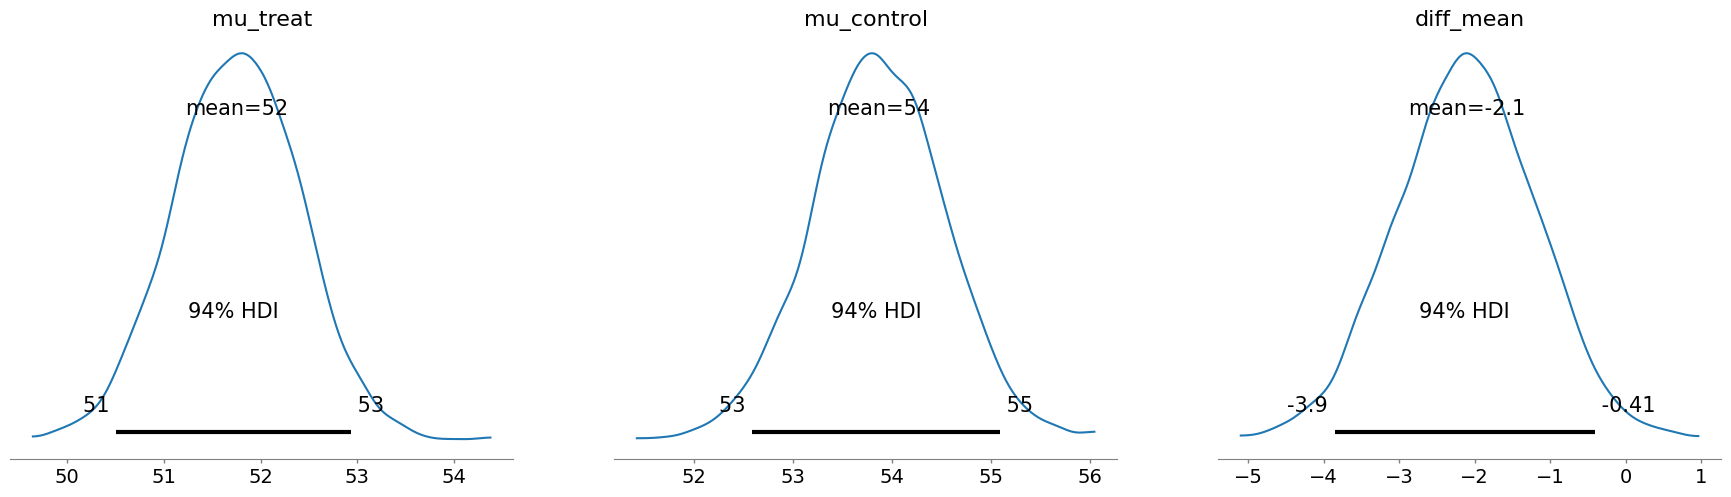

In [231]:
# print and show all the result

posterior_diff_means = trace.posterior['diff_mean'].values
ci_lower, ci_upper = np.percentile(trace.posterior['diff_mean'], [2.5, 97.5])

print("Difference in means posterior mean:", round(posterior_diff_means.mean(), 3))
print("Difference in means 95% credible interval:", round(ci_lower, 3), 'to', round(ci_upper, 3))

pm.plot_posterior(trace.posterior)
plt.show()

### 3.2.3. Inference of Bayesian Statistics

#### 3.2.3.1. Retention

The results indicate that the treatment group (gate at level 40) did not perform significantly better than the control group (gate at level 30). In fact, there is **a 0.6% probability that the treatment group performed worse than the control** based on the Bayes analysis. Therefore, based on this very low probability, we might conclude that there is no meaningful difference between placing the gate at level 30 versus level 40.

#### 3.2.3.2. Gamerounds

In a Bayesian t-test, you can infer the result by examining the posterior distribution of the parameter of interest, such as the difference in means between two groups. The posterior distribution provides a range of plausible values for the parameter, along with their respective probabilities.

The **credible interval** is a Bayesian counterpart to the frequentist confidence interval. It is an **interval estimate that contains the true value of the parameter with a specified probability, often 95%** (similar to a 95% confidence interval in frequentist statistics). In Bayesian analysis, the credible interval is interpreted as the range of values within which the true parameter value falls with a specified probability, based on the observed data and the prior information.

What's the difference between credible interval and confidence interval? Let's use some examples, with lower bound of 70, and upper bound of 82:

- **Confidence Interval**: A 95% confidence interval (CI) of the mean is a range with an upper and lower number calculated from a sample. Because the true population mean is unknown, this range describes possible values that the mean could be.
- **Credible Interval**: A 95% credible interval indicates a 95% probability that the true parameter value lies within that interval, given the observed data and the prior distribution.

In a nutshell, we can say that in CI, we're talking about the **probability for the true population**. While for the credible interval, we're talking about the **probability of the posterior parameter itself**.

Thus with the previous result, we can make a conclusion as:

Based on the Bayesian t-test analysis, we can conclude that there is strong evidence to suggest that the treatment group performs, on average, 2.791 units worse than the control group. This conclusion is based on the 95% credible interval, which suggests that the true difference in means between the two groups is likely to fall between -4.579 and -1.001 units.

In practical terms, this means that the treatment may not be as effective as the control in achieving the desired outcome. Business decisions based on this analysis might include reconsidering the implementation of the treatment or exploring alternative strategies to improve performance.

## 3.3. Extra - Analytical vs. Numerical Approximations

In our coding examples using PyMC, you might have noticed that we used analytical or numerical to calculate the parameter. What are those?

- **Analytical Methods**:

Analytical methods seek exact solutions to equations through algebraic and mathematical operations. These methods involve manipulating equations algebraically to isolate the variable of interest and solve for its value. Analytical methods are used to find closed-form solutions, which are formulas that can be evaluated in a finite number of standard operations. For example, consider the quadratic formula:

$ax^2 + bx + c = 0$

The solution for $x$ can be found using the quadratic formula:

$x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$

However, for equations like a fifth-order polynomial:

$ax^5 + bx^4 + cx^3 + dx^2 + ex + f = 0$

There is no general formula to directly find the roots in a closed form. In such cases, we turn to numerical approximation.

- **Numerical Approximation**:

Numerical methods involve approximating solutions to equations using iterative procedures and numerical calculations. For example, Newton's method is a popular numerical method:

- It starts with an initial guess for a solution.
- It then uses that value to calculate a better guess at a solution.
- This process continues, with each iteration providing a better approximation to the solution.
- Newton's method rapidly converges to an excellent approximation for a solution.

Another popular method for approximating parameters in Bayesian statistics is Markov Chain Monte Carlo (MCMC), which we will explain next.

### 3.3.1. Markov Chain Monte Carlo (MCMC)

1. **Markov Chain:** 
   - A Markov chain is a sequence of random variables where the probability of each variable depends only on the state of the previous variable. 
   - In the context of MCMC, the Markov chain represents a sequence of samples from a probability distribution that we want to approximate.

2. **Monte Carlo:**
   - Monte Carlo methods use random sampling to obtain numerical results. 
   - In the context of MCMC, Monte Carlo methods are used to sample from the probability distribution of interest.

3. **How MCMC Works:**
   - MCMC methods, like the Metropolis-Hastings algorithm, start with an initial guess or "state" and iteratively generate new samples.
   - At each iteration, a new sample is proposed based on the current state, and its acceptance is determined probabilistically.
   - If the new sample is accepted, it becomes the next state of the Markov chain; otherwise, the current state remains.

4. **Metropolis-Hastings Algorithm:**
   - Given a target distribution \( p(x) \), the algorithm works as follows:
     1. Start with an initial state \( x_0 \).
     2. For each iteration:
        - Propose a new state \( x' \) based on a proposal distribution \( q(x'|x) \).
        - Calculate the acceptance ratio \( \alpha = \frac{p(x')q(x|x')}{p(x)q(x'|x)} \).
        - Generate a random number \( u \) from a uniform distribution.
        - If \( u \leq \alpha \), accept \( x' \) as the next state; otherwise, reject \( x' \) and keep \( x \) as the next state.

5. **Calculations:**
   - For example, let's say we want to estimate the mean of a normal distribution with unknown mean \( \mu \) and known standard deviation \( \sigma \). We can use MCMC to sample from the posterior distribution of \( \mu \) given some observed data.
   - The likelihood of the data given \( \mu \) is \( p(x|\mu) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x-\mu)^2}{2\sigma^2}} \).
   - The prior distribution of \( \mu \) is \( p(\mu) \).
   - The posterior distribution of \( \mu \) is proportional to the product of the likelihood and the prior: \( p(\mu|x) \propto p(x|\mu)p(\mu) \).
   - By sampling from this posterior distribution using MCMC, we can approximate the mean of the distribution.

In summary, MCMC is a powerful method for approximating complex probability distributions by iteratively sampling from them. It is widely used in Bayesian statistics and probabilistic machine learning to estimate unknown parameters and make predictions.

# Reading References

- Power Analysis Formula: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_power/bs704_power_print.html#:~:text=Power%20is%20defined%20as%201,outcome%20and%20the%20effect%20size.
- Sample Size Calculator: https://www.evanmiller.org/ab-testing/sample-size.html
- More on Markov Chain Monte Carlo: https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/